# Tests for quering local PBF osm files

guide for using the filter https://pypi.org/project/esy-osmfilter/


## imports

In [13]:
import configparser, contextlib
import os, sys

from esy.osmfilter import osm_colors as CC
from esy.osmfilter import run_filter 
from esy.osmfilter import Node, Way, Relation

import urllib.request


## Get file

In [43]:
city_name = 'liechtenstein-latest'
c = 'berlin-latest'

In [44]:
PBF_inputfile = os.path.join(os.getcwd(), f'test-osmfilter/{city_name}.osm.pbf')
JSON_outputfile = os.path.join(os.getcwd(), f'test-osmfilter/{city_name}.json')

In [45]:
PBF_inputfile

'/home/laia/code/Laiagdla/livablestreets/notebooks/test-osmfilter/liechtenstein-latest.osm.pbf'

In [46]:
if not os.path.exists(f'test-osmfilter/{city_name}.osm.pbf'):
    filename, headers = urllib.request.urlretrieve(
        f'https://download.geofabrik.de/europe/{city_name}.osm.pbf',
        filename=f'test-osmfilter/{city_name}.osm.pbf')
PBF_inputfile = filename

## Filter main data

In [47]:
prefilter   = {Node: {}, Way: {"man_made":["pipeline",],}, Relation: {}}
blackfilter = [("pipeline","substation"),]
whitefilter =[(("waterway","drain"),("name","Wäschgräble")), ]

In [48]:
>>> [Data,_]=run_filter('noname',
...                     PBF_inputfile, 
...                     JSON_outputfile, 
...                     prefilter,
...                     whitefilter, 
...                     blackfilter, 
...                     NewPreFilterData=True, 
...                     CreateElements=False, 
...                     LoadElements=False,
...                     verbose=True)

INFO:esy.osmfilter.pre_filter:PreFilter OSM GAS DATA
INFO:esy.osmfilter.pre_filter:InputFile     : test-osmfilter/liechtenstein-latest.osm.pbf
INFO:esy.osmfilter.pre_filter:Size          : 2692            kbyte
INFO:esy.osmfilter.pre_filter:Estimated Time: 0.38            s
INFO:esy.osmfilter.pre_filter:=============================
INFO:esy.osmfilter.pre_filter:0.5
INFO:esy.osmfilter.pre_filter:1
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pr

In [49]:
>>> len(Data['Node'])

203

In [50]:
>>> len(Data['Relation'])

0

In [51]:
>>> len(Data['Way'])

45

## Filter out (blackfilter)

In [52]:
>>> [_,Elements]=run_filter('funny-waterway-pipelines',
...                            PBF_inputfile, 
...                            JSON_outputfile, 
...                            prefilter,
...                            whitefilter, 
...                            blackfilter, 
...                            NewPreFilterData=False, 
...                            CreateElements=True, 
...                            LoadElements=False,
...                            verbose=True)
>>> len(Elements['funny-waterway-pipelines']['Node'])
0
>>> len(Elements['funny-waterway-pipelines']['Relation'])
0
>>> len(Elements['funny-waterway-pipelines']['Way'])

1

## save geojson

In [54]:
>>> from esy.osmfilter import export_geojson
>>> export_geojson(Elements['funny-waterway-pipelines']['Way'],Data,
... filename=f'test-osmfilter/{city_name}.geojson',jsontype='Line')

## open geosjon

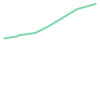

In [62]:
import geopandas as gpd
elements = gpd.read_file(f'test-osmfilter/{city_name}.geojson')
elements['geometry'][0]

# shapely, create geometry from geojson

In [57]:
import shapely.geometry as geometry
from shapely.ops import linemerge, unary_union, polygonize

In [63]:
from shapely.geometry import Polygon

Polygon([tuple(l) for l in elements['geometry'][0]])

TypeError: 'LineString' object is not iterable

# test

In [65]:
prefilter   = {Node: {}, Way: {"highway":["cycleway",],}, Relation: {}}


[Data,_]=run_filter('noname',
                    PBF_inputfile, 
                    JSON_outputfile, 
                    prefilter,
                    whitefilter, 
                    blackfilter, 
                    NewPreFilterData=True, 
                    CreateElements=False, 
                    LoadElements=False,
                    verbose=True)

INFO:esy.osmfilter.pre_filter:PreFilter OSM GAS DATA
INFO:esy.osmfilter.pre_filter:InputFile     : test-osmfilter/liechtenstein-latest.osm.pbf
INFO:esy.osmfilter.pre_filter:Size          : 2692            kbyte
INFO:esy.osmfilter.pre_filter:Estimated Time: 0.38            s
INFO:esy.osmfilter.pre_filter:=============================
INFO:esy.osmfilter.pre_filter:0.5
INFO:esy.osmfilter.pre_filter:1
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pr

In [66]:
>>> len(Data['Way'])

214

In [73]:
export_geojson(Data['Way'],
filename=f'test-osmfilter/{city_name}.geojson',jsontype='Line')

TypeError: export_geojson() missing 1 required positional argument: 'Data'